In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
import os
import math
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

DATA_DIR = '/users/zoehsieh/Desktop/Comp135/Project A/'

x_train = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_test = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)
y_train = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)

In [7]:
def calc_mean_binary_cross_entropy_from_probas(ytrue_N, yproba1_N):
    ''' Compute mean binary cross entropy
    
    Args
    ----
    ytrue_N : 1D array, size (n_examples,) = (N,)
    yproba1_N : 1D array, size (n_examples,) = (N,)
    
    Returns
    -------
    mean_bce : float
        mean binary cross entropy across all N examples
    '''
    return sklearn.metrics.log_loss(ytrue_N, yproba1_N, labels=[0,1]) / np.log(2.0)

In [8]:
def split_into_train_and_valid(x_all_LF, y_all_L, frac_valid=0.5, random_state=None):
    ''' Divide provided array into train and test sets along first dimension

    User can provide random number generator object to ensure reproducibility.

    Args
    ----
    x_all_LF : 2D np.array, shape = (n_total_examples, n_features) (L, F)
    y_all_LF : 1D np.array, shape = (L,)
    frac_valid : float, fraction between 0 and 1
        Indicates fraction of all L examples to allocate to the "test" set
        Returned test set will round UP if frac_valid * L is not an integer.
        e.g. if L = 10 and frac_valid = 0.31, then test set has N=4 examples
    random_state : np.random.RandomState instance or integer or None
        If int, will create RandomState instance with provided value as seed
        If None, defaults to current numpy random number generator np.random.

    Returns
    -------
    x_train_MF : 2D np.array, shape = (n_train_examples, n_features) (M, F)
        Each row is a feature vector
        Should be a separately allocated array, NOT a view of any input array

    x_valid_NF : 2D np.array, shape = (n_valid_examples, n_features) (N, F)
        Each row is a feature vector
        Should be a separately allocated array, NOT a view of any input array
        
    y_train_M : 1D np.array, shape + (n_train_examples) (M,)
    
    y_valid_N : 1D np.array, shape = (n_valid_examples) (N,)
   
    '''
    from sklearn.utils import shuffle
    
    # M = number of train rows
    # N = number of test rows
    # L = number of source rows
    # F = number of source columns

    # Calculate number of rows that will be for train vs. test
    L, F = x_all_LF.shape
    N = int(np.ceil(frac_valid * L))
    M = L - N

    # Create new empty numpy arrays that will store the split train 
    # and test data
    x_valid_NF = np.zeros((N, F))
    x_train_MF = np.zeros((M, F))
    y_valid_N = np.zeros(N)
    y_train_M = np.zeros(M)
    
    shuffled_x, shuffled_y = shuffle(x_all_LF, y_all_L, random_state=random_state)
    
    # Copy the first N rows from randomized to x_valid_NF
    for i in range(0, N):
        x_valid_NF[i] = shuffled_x[i]
        y_valid_N[i] = shuffled_y[i]

    # Copy the last M rows from randomized to x_train_MF
    j = 0
    for i in range(N, L):
        x_train_MF[j] = shuffled_x[i]
        y_train_M[j] = shuffled_y[i]
        j += 1

    return x_train_MF, x_valid_NF, y_train_M, y_valid_N

In [38]:
x_train, x_valid, y_train, y_valid = split_into_train_and_valid(x_train, y_train, frac_valid=0.2, random_state=1)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(7680, 784)
(1920, 784)
(7680,)
(1920,)
1920


In [10]:
def calc_ACC(ytrue_N, yhat_N):

    ''' Compute the accuracy of provided predicted binary values.
    
    Args

    ----

    ytrue_N : 1D array of floats, shape (n_examples,) = (N,)

        All values must be either 0.0 or 1.0.

        Each entry represents the binary 'true' label of one example

        One entry per example in current dataset

    yhat_N : 1D array of floats, shape (n_examples,) = (N,)

        All values must be either 0.0 or 1.0.

        Each entry represents a predicted label for one example

        One entry per example in current dataset.

        Needs to be same size as ytrue_N.

    Returns

    -------

    acc : float

        Accuracy = ratio of number correct over total number of examples

    '''

    # TODO compute accuracy
    # You should *use* your calc_TP_TN_FP_FN function from above
    # Hint: make sure denominator will never be exactly zero
    # by adding a small value like 1e-10

    size = len(yhat_N)

    num_acc = 0
    for i in range(size):
        if yhat_N[i] == 1:
            if ytrue_N[i] == 1:
                num_acc = num_acc +1
        else:
            if ytrue_N[i] == 0:
                num_acc = num_acc +1 

    if size == 0:
        size = 0.0000001
        
    return num_acc/size

In [35]:
# Baseline

C_grid = np.logspace(-9, 6, 31)

# Store binary cross entropy (bce) for all C in C_grid;
# So we can compare and select the best C in the future steps.
tr_bce_list = list()
val_bce_list = list()
tr_err_list = list()
val_err_list = list()


for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize your LogisticRegression classifier 
    # Part b: train the model with the 2-feature dataset
    lr = sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs')

    lr.fit(x_train, y_train) 
    
    '''
    yproba_train = lr.predict_proba(x_train)[:,1] # The probability of predicting class 1 on the training set
    
    tr_err_list.append(sklearn.metrics.zero_one_loss(y_train, yproba_train >= 0.5)) # Error rate for training set. 
    
    my_tr_bce = calc_mean_binary_cross_entropy_from_probas(y_train, yproba_train) 
    
    tr_bce_list.append(my_tr_bce) 
    
    yhat_val = lr.predict(x_valid)
    val_err_list.append(sklearn.metrics.zero_one_loss(y_valid, yhat_val)) 
    
    '''
    
    yhat_train = lr.predict(x_train) # The probability of predicting class 1 on the training set
    yhat_valid = lr.predict(x_valid)
    
    tr_err_list.append(sklearn.metrics.zero_one_loss(y_train, yhat_train)) # Error rate for training set. 
    val_err_list.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid)) # Error rate for validation set.
    tr_bce_list.append(sklearn.metrics.log_loss(y_train, yhat_train))
    val_bce_list.append(sklearn.metrics.log_loss(y_valid, yhat_valid))
    
    
    
index = np.argmin(tr_err_list)

best_C_base = C_grid[index]

print("Best C value for Baseline:")
print(best_C_base)

val_in = np.argmin(val_err_list)
print(C_grid[val_in])

lr_best_C = sklearn.linear_model.LogisticRegression(C = best_C_base, solver='lbfgs')

lr_best_C.fit(x_train, y_train)
y_hat_base = lr_best_C.predict(x_valid)
y_hat_base_train = lr_best_C.predict(x_train)
np.savetxt('y_hat_base.txt', y_hat_base)


acc_base = calc_ACC(y_valid, y_hat_base)

print(sklearn.metrics.accuracy_score(y_valid, y_hat_base))


print(acc_base)
print(1 - acc_base)


#print(np.sum(y_hat_base))


/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Best C value for Baseline:
31.622776601683793
1.0
0.955
0.955
0.04500000000000004


/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# Transformation 1 - Add column that sums the total number of black pixels per image

def trans1(train):
    N,F = train.shape
    new_col = []
    for i in range(N):
        total = 0
        for j in range(F):
            if (train[i][j] == 0):
                total += 1
        new_col = np.append(new_col, total)
    new_col = np.array(new_col)
    new_col = new_col.reshape(N, 1)
    x_train_trans = np.hstack((train, new_col))
    return x_train_trans

x_train_trans1 = trans1(x_train)
x_valid_trans = trans1(x_valid)

print(x_train_trans1.shape)
print(y_train.shape)

(7680, 785)
(7680,)


In [42]:
# transform -- part 1
C_grid = np.logspace(-9, 6, 31)

# Store binary cross entropy (bce) for all C in C_grid;
# So we can compare and select the best C in the future steps.
tr_bce_list1 = list()

# Store the error rate: Fraction of examples that are mis-classified (using threshold=0.5)
# (We visualize it later, but don't use it in the report).
# Remember, we justified using BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.
tr_err_list1 = list()



for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize your LogisticRegression classifier 
    # Part b: train the model with the 2-feature dataset
    lr_trans = sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs')
    

    lr_trans.fit(x_train_trans1, y_train) 
    
    '''
    yproba1_train_trans1 = lr_trans.predict_proba(x_train_trans1)[:,1] # The probability of predicting class 1 on the training set
    
    tr_err_list1.append(sklearn.metrics.zero_one_loss(y_train, yproba1_train_trans1 >= 0.5)) # Error rate for training set. 
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce1= calc_mean_binary_cross_entropy_from_probas(y_train, yproba1_train_trans1) 
    
    # Save bce for future selection on Models.
    tr_bce_list1.append(my_tr_bce1) 
    '''
    
    yhat_train = lr_trans1.predict(x_train_trans1) # The probability of predicting class 1 on the training set
    yhat_valid = lr_trans1.predict(x_valid_trans)
    
    tr_err_list.append(sklearn.metrics.zero_one_loss(y_train, yhat_train)) # Error rate for training set. 
    val_err_list.append(sklearn.metrics.zero_one_loss(y_valid, yhat_valid)) # Error rate for validation set.
    tr_bce_list.append(sklearn.metrics.log_loss(y_train, yhat_train))
    val_bce_list.append(sklearn.metrics.log_loss(y_valid, yhat_valid))
    



index1 = np.argmin(tr_bce_list)

best_C_1= C_grid[index1]

print("Best C value for transformed (1):")
print(best_C_1)

lr_trans1 = sklearn.linear_model.LogisticRegression(C = best_C_1, solver='lbfgs')

lr_trans1.fit(x_train_trans1, y_train)
x_val_trans1 = trans1(x_valid)
y_hat1 = lr_trans1.predict(x_val_trans1)
x_train_trans = trans1(x_train)
y_hat1_train = lr_trans1.predict(x_train_trans)
np.savetxt('y_hat1_train.txt', y_hat1_train)





/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Best C value for transformed (1):
31.622776601683793


/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
acc_trans1 = calc_ACC(y_valid, y_hat1)
print(1 - acc_trans1)

0.047083333333333366


In [15]:
# transformation 3 - flip images and use twice as many input data points

# make new function for a different transformation, hstack, and repeat

print(y_train.shape)
print(x_train.shape)
def trans3(x_data):
    #x_trans = []
    
    #for i in x_data:
        #x_trans.append(i)
        
    #for a in x_data:
        #new_elem = np.fliplr(a)
        #x_trans[a,:].append(new_elem)    
    
    new_elem = np.fliplr(x_data)
    
    
    return np.append(x_data, new_elem, axis = 1)

x_train_trans3 = trans3(x_train)
print(x_train_trans3.shape)


(9600,)
(9600, 784)
(9600, 1568)


In [16]:
# transform3
C_grid = np.logspace(-9, 6, 31)

# Store binary cross entropy (bce) for all C in C_grid;
# So we can compare and select the best C in the future steps.
tr_bce_list3 = list()

# Store the error rate: Fraction of examples that are mis-classified (using threshold=0.5)
# (We visualize it later, but don't use it in the report).
# Remember, we justified using BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.
tr_err_list3 = list()

for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize your LogisticRegression classifier 
    # Part b: train the model with the 2-feature dataset
    lr_trans3 = sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs')

    lr_trans3.fit(x_train_trans3, y_train) 
    
    yproba1_train_trans3 = lr_trans3.predict_proba(x_train_trans3)[:,1] # The probability of predicting class 1 on the training set
    
    tr_err_list3.append(sklearn.metrics.zero_one_loss( y_train, yproba1_train_trans3 >= 0.5)) # Error rate for training set. 
    
    # TODO: using the calc_mean_binary_cross_entropy_from_probas() function from above:
    # Part c: calculate the binary cross entropy (bce) on the training set
    # Part d: calculate the binary cross entropy (bce) on the validation set
    my_tr_bce3 = calc_mean_binary_cross_entropy_from_probas( y_train, yproba1_train_trans3) 
    
    # Save bce for future selection on Models.
    tr_bce_list3.append(my_tr_bce3)
    
index3 = np.argmin(tr_bce_list3)


best_C3 = C_grid[index3]

print("Best C value for transformed (3):")
print(best_C3)


/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

Best C value for transformed (3):
3162.2776601683795


/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
lr_trans3 = sklearn.linear_model.LogisticRegression(C = best_C3, solver='lbfgs')

lr_trans3.fit(x_train_trans3, y_train)
x_val_trans3 = trans3(x_valid)
y_hat3 = lr_trans3.predict(x_val_trans3)
x_train_trans3 = trans3(x_train)
y_hat3_train = lr_trans3.predict(x_train_trans3)
np.savetxt('y_hat3_train.txt', y_hat3_train)

acc_trans3 = calc_ACC(y_valid, y_hat3)
print(1 - acc_trans3)

0.04874999999999996


/Users/zoehsieh/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


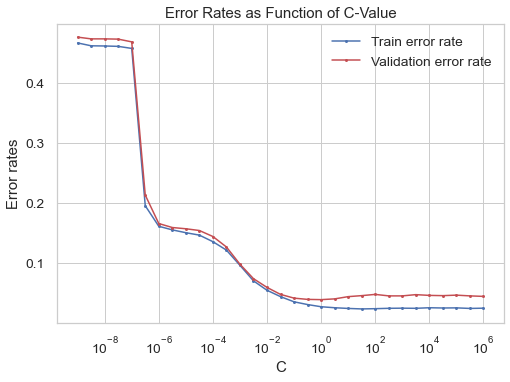

In [37]:
# Results 1

# plot baseline's train vs val set on best hyperparameter
# plot training error and val vs c


# tr_err_list
# val_err_list


plt.plot(C_grid, tr_err_list, 'b.-', label='Train error rate')
plt.plot(C_grid, val_err_list, 'r.-', label='Validation error rate')


plt.title("Error Rates as Function of C-Value");
plt.xlabel('C');
plt.ylabel('Error rates');
plt.legend(loc='upper right');
#B = 0.01
#plt.xlim([0 - B, 1 + B]);
#plt.ylim([0 - B, 1 + B]);


plt.xscale("log")


# train - 31.622
# val - 1.0

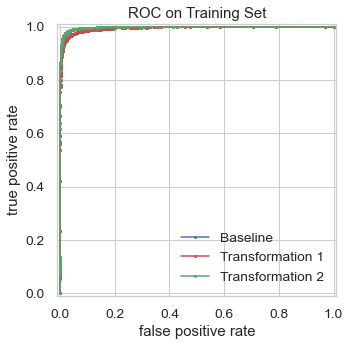

In [20]:
# Training -- ROC curve

# plot ROC for train and val for base, trans1,  and trans 2 
# each one has training, 


# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

#TODO Using your data and predictions of the Validation set, Produce the ROC Curve utilizing  
#     `sklearn.metrics.roc_curve' within plt defined above.
#     To Start with, Google and Read the official Document and examples of 'sklearn.metrics.roc_curve'. 

#     Read the instruction of HW2 carefully about the requirements of your plot (line type, line color, etc.)

#sklearn.metric.roc_curve(bestlrF2_yproba1_va_N, bestlrF3_yproba1_va_N)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_train, yproba_train)
fpr1, tpr1, thresholds1 = sklearn.metrics.roc_curve(y_train, yproba1_train_trans1)
fpr3, tpr3, thresholds3 = sklearn.metrics.roc_curve(y_train, yproba1_train_trans3)
plt.plot(fpr, tpr, 'b.-', label='Baseline')
plt.plot(fpr1, tpr1, 'r.-', label='Transformation 1')
plt.plot(fpr3, tpr3, 'g.-', label='Transformation 2')


plt.title("ROC on Training Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

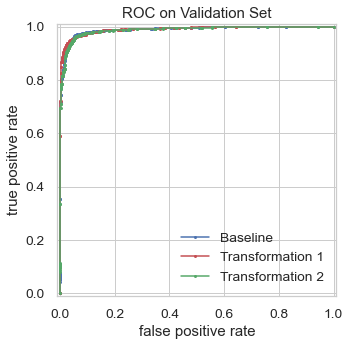

In [21]:
# Heldout -- ROC curve

# plot ROC for train and val for base, trans1,  and trans 2 
# put as one figure


# Follow the instruction of HW2 and produce Figure 1 for your report:
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

#TODO Using your data and predictions of the Validation set, Produce the ROC Curve utilizing  
#     `sklearn.metrics.roc_curve' within plt defined above.
#     To Start with, Google and Read the official Document and examples of 'sklearn.metrics.roc_curve'. 

#     Read the instruction of HW2 carefully about the requirements of your plot (line type, line color, etc.)

#sklearn.metric.roc_curve(bestlrF2_yproba1_va_N, bestlrF3_yproba1_va_N)


yproba_val = lr_best_C.predict_proba(x_valid)
yproba_val_trans1 = lr_trans1.predict_proba(x_val_trans1)
yproba_val_trans3 = lr_trans3.predict_proba(x_val_trans3)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_valid, yproba_val[:,1])
fpr1, tpr1, thresholds1 = sklearn.metrics.roc_curve(y_valid, yproba_val_trans1[:,1])
fpr3, tpr3, thresholds3 = sklearn.metrics.roc_curve(y_valid, yproba_val_trans3[:,1])

plt.plot(fpr, tpr, 'b.-', label='Baseline')
plt.plot(fpr1, tpr1, 'r.-', label='Transformation 1')
plt.plot(fpr3, tpr3, 'g.-', label='Transformation 2')


plt.title("ROC on Validation Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

In [30]:
yproba_val = lr_best_C.predict_proba(x_valid)
yproba_val_trans1 = lr_trans1.predict_proba(x_val_trans1)
yproba_val_trans3 = lr_trans3.predict_proba(x_val_trans3)

#submit second column
x_test_trans3 = trans3(x_test)
x_test_trans1 = trans1(x_test)


yproba_test_trans3 = lr_trans3.predict_proba(x_test_trans3)[:,1]
np.savetxt('yproba_test_trans3.txt', yproba_test_trans3)


yproba_test_trans1 = lr_trans.predict_proba(x_test_trans1)[:,1]
np.savetxt('yproba_test_trans1.txt', yproba_test_trans1)

